# Speed dating machine learning


In [792]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

In [793]:
df = pd.read_csv('speed_dating.csv')
df.head()

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,match
0,0,1.0,female,21.0,27.0,6.0,[4-6],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,...,4.0,[0-4],[0-3],[3-5],7.0,6.0,[6-8],[5-6],0.0,0
1,0,1.0,female,21.0,22.0,1.0,[0-1],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,...,4.0,[0-4],[0-3],[3-5],7.0,5.0,[6-8],[5-6],1.0,0
2,1,1.0,female,21.0,22.0,1.0,[0-1],Asian/Pacific Islander/Asian-American,Asian/Pacific Islander/Asian-American,1,...,4.0,[0-4],[0-3],[3-5],7.0,5.0,[6-8],[0-4],1.0,1
3,0,1.0,female,21.0,23.0,2.0,[2-3],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,...,4.0,[0-4],[0-3],[3-5],7.0,6.0,[6-8],[5-6],0.0,1
4,0,1.0,female,21.0,24.0,3.0,[2-3],Asian/Pacific Islander/Asian-American,Latino/Hispanic American,0,...,4.0,[0-4],[0-3],[3-5],6.0,6.0,[6-8],[5-6],0.0,1


## Feature Engineering
There are more than one hundred features in the dataset,in which 59 are categorical features. By exploring the features, we find there is only one feature, 'field', that has a high range of values, rest 'object'-features have 3-5 different values. Thus, we can use one-hot encoding to encode the features. Worth note: it may lead to sparse features. 

For the 'field' feature, by feature exploration, we also find that there are some values are only different because of the Capital letter, so we first transform the values of the 'field' feature to lowercase, then encode it with count encoding (frequency encoding) instead of one-hot encoding which leads to feature explosion. The 'field' feature in the end has 219 different values, 40 less compared to it before letter transformation.

Some features are highly correlated with other feature(s) such as those denote the differences between two other features, so I will drop these features of differences of other feature(s), for example 'd_d_age', 'd_importance_same_race', *etc*.

In [794]:
df['field'] = df['field'].str.lower()
X = df.copy()
y = pd.DataFrame(df.pop('match'), columns =['match'])
X = X.loc[:, ~X.columns.str.contains('d_')]
X.drop('match', axis=1, inplace=True)
# X.drop('has_null', axis=1, inplace=True)
X.head()

,has_null,wave,gender,age,age_o,race,race_o,samerace,importance_same_race,importance_same_religion,...,theater,movies,concerts,music,shopping,yoga,interests_correlate,like,guess_prob_liked,met
0,0,1.0,female,21.0,27.0,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,...,1.0,10.0,10.0,9.0,8.0,1.0,0.14,7.0,6.0,0.0
1,0,1.0,female,21.0,22.0,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,...,1.0,10.0,10.0,9.0,8.0,1.0,0.54,7.0,5.0,1.0
2,1,1.0,female,21.0,22.0,Asian/Pacific Islander/Asian-American,Asian/Pacific Islander/Asian-American,1,2.0,4.0,...,1.0,10.0,10.0,9.0,8.0,1.0,0.16,7.0,5.0,1.0
3,0,1.0,female,21.0,23.0,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,...,1.0,10.0,10.0,9.0,8.0,1.0,0.61,7.0,6.0,0.0
4,0,1.0,female,21.0,24.0,Asian/Pacific Islander/Asian-American,Latino/Hispanic American,0,2.0,4.0,...,1.0,10.0,10.0,9.0,8.0,1.0,0.21,6.0,6.0,0.0


In [795]:
Xtrain = X.copy()
ytrain = y.copy()

In [63]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)
# Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.1/0.8, random_state=42)

In [796]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders.count import CountEncoder

ohe = OneHotEncoder()
std = StandardScaler()
cte = CountEncoder()

In [797]:
cat_col = Xtrain.select_dtypes(include='object').columns.drop('field')
num_col = Xtrain.drop(columns=cat_col).columns.drop('field')
field_col = Xtrain.drop(columns=num_col).columns.drop(cat_col)

In [798]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

count_transformer = Pipeline(steps=[
    ('count', CountEncoder(handle_unknown='ignore'))
])

num_transformer = Pipeline(steps=[
    ('numeric', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_col),
        ('cat', cat_transformer, cat_col),
        ('count', count_transformer, field_col)
    ]
)

preprocessor.fit(Xtrain)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('numeric',
                                                  StandardScaler())]),
                                 Index(['has_null', 'wave', 'age', 'age_o', 'samerace', 'importance_same_race',
       'importance_same_religion', 'pref_o_attractive', 'pref_o_sincere',
       'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious',
       'attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o', 'ambitous_o',
       'att...
       'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga',
       'interests_correlate', 'like', 'guess_prob_liked', 'met'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['gender', 'race', 'race_o'], dtype='object')),
                                ('count',
                                 Pipeline(steps=[('count',
                                                  CountEncoder(combine_min_nan_groups=True,
                                                               handle_unknown='ignore'))]),
                                 Index(['field'], dtype='object'))])

In [806]:
Xtrain_encoded = preprocessor.transform(Xtrain)
# Xtest_encoded = preprocessor.transform(Xtest)

In [807]:
print(Xtrain.shape)
Xtrain_encoded.shape

(8378, 57)


(8378, 66)

In [808]:
# get the numerical feature names
num_names_in = []
for i in range(num_col.shape[0]):
    num_names_in.append(num_col[i])
numeric_transformer = preprocessor.named_transformers_['num']
std_scaler = numeric_transformer.named_steps['numeric']
numeric_names = std_scaler.get_feature_names_out(num_col)

# get the categorical feature names
categorical_transformer = preprocessor.named_transformers_['cat']
cat_scaler = categorical_transformer.named_steps['onehot']
cat_names = cat_scaler.get_feature_names_out(cat_col)

# get the field names
field_transformer = preprocessor.named_transformers_['count']
field_scaler = field_transformer.named_steps['count']
field_names = field_scaler.feature_names_out_

encoded_num_cols = num_col
encoded_cat_cols = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_col)
encoded_count_cols = field_col

encoded_feature_names = np.concatenate((encoded_num_cols, encoded_cat_cols, encoded_count_cols))


# convert the encoded data to a DataFrame with the corresponding column names
Xtrain_encoded_df = pd.DataFrame(Xtrain_encoded, columns=encoded_feature_names)


['has_null' 'wave' 'age' 'age_o' 'samerace' 'importance_same_race'
 'importance_same_religion' 'pref_o_attractive' 'pref_o_sincere'
 'pref_o_intelligence' 'pref_o_funny' 'pref_o_ambitious' 'attractive_o'
 'sinsere_o' 'intelligence_o' 'funny_o' 'ambitous_o'
 'attractive_important' 'sincere_important' 'intellicence_important'
 'funny_important' 'ambtition_important' 'attractive' 'sincere'
 'intelligence' 'funny' 'ambition' 'attractive_partner' 'sincere_partner'
 'intelligence_partner' 'funny_partner' 'ambition_partner' 'sports'
 'tvsports' 'exercise' 'dining' 'museums' 'art' 'hiking' 'gaming'
 'clubbing' 'reading' 'tv' 'theater' 'movies' 'concerts' 'music'
 'shopping' 'yoga' 'interests_correlate' 'like' 'guess_prob_liked' 'met']
(12,)
['field']


In [398]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, DBSCAN, Birch, OPTICS, Birch
import numpy as np

def build_model(n_clusters=2, 
                init='random', n_init='auto', max_iter=300, tol=1e-4, random_state=None, algorithm_k='lloyd', verbose=0,    # parameters for kmeans model
                cluster_method='xi', min_cluster_size=None,   # parameters for optics model
                threshold=0.5, branching_factor=50,   # parameters for birch model
                algorithm='auto', eps=15, min_samples=5, metric='euclidean', metric_params = None, leaf_size=30, p=2, n_jobs=1    # parameters for dbscan model
                ):
    randomforest = Pipeline(steps=[
        ('preprocessor', preprocessor), 
        ('model', RandomForestClassifier)])

    kmeans = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', KMeans(n_clusters=n_clusters,
                        init=init,
                        n_init=n_init, 
                        max_iter=max_iter, 
                        tol=tol,
                        verbose=verbose,
                        random_state=random_state, 
                        algorithm=algorithm_k))])

    optics = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', OPTICS(min_samples=min_samples,
                        max_eps=np.inf, 
                        metric=metric, 
                        p=p, 
                        cluster_method=cluster_method, 
                        min_cluster_size=min_cluster_size, 
                        algorithm=algorithm, 
                        leaf_size=leaf_size))])

    birch = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', Birch(threshold=threshold,
                        n_clusters=n_clusters, 
                        branching_factor=branching_factor,
                        ))])

    dbscan = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', DBSCAN(eps=eps, 
                        min_samples=min_samples, 
                        metric=metric, 
                        metric_params=metric_params, 
                        leaf_size=leaf_size, 
                        p=p,
                        n_jobs=n_jobs))])
    return randomforest, kmeans, optics, birch, dbscan


In [339]:
from sklearn.manifold import TSNE, MDS, SpectralEmbedding
import umap

# umap_reducer = umap.UMAP(n_components=4)
# umap_embeding = umap_reducer.fit_transform(Xtrain_encoded)

tsne_reducer = TSNE(n_components=2, perplexity=50, method='barnes_hut', random_state=42)
tsne_embeding_train = tsne_reducer.fit_transform(Xtrain_encoded)
# tsne_embeding_test = tsne_reducer.fit_transform(Xtest_encoded)
# tsne_embeding_val = tsne_reducer.fit_transform(Xval_encoded)

In [17]:
my_palette = sns.color_palette(n_colors=25)

#### DBSCAN

'sokalmichener', 'rogerstanimoto', 'cosine', 'braycurtis', 'sokalsneath', 'dice', 'nan_euclidean', 'precomputed', 'l2', 'matching', 'canberra', 'l1', 'yule', 'cityblock', 'kulsinski', 'correlation', 'jaccard', 'sqeuclidean', 'euclidean', 'haversine', 'seuclidean', 'hamming', 'wminkowski', 'russellrao', 'manhattan', 'mahalanobis', 'minkowski', 'chebyshev'

当前最佳参数组合：eps=11, min_samples=181, metric='chebyshev': silhouette score: 0.7121166454500091

备选参数组合：eps=12, min_samples=152, metric='minkowski', algorithm='kd_tree', p=3: silhouette score: 0.7121166454500091

In [343]:
models = build_model(eps=6, min_samples=10, metric='minkowski', algorithm='kd_tree', leaf_size=30, p=3, n_jobs=-1)
dbscan_model = models[-1]
dbscan_model.fit(Xtrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numeric',
                                                                   StandardScaler())]),
                                                  Index(['has_null', 'wave', 'age', 'age_o', 'samerace', 'importance_same_race',
       'importance_same_religion', 'pref_o_attractive', 'pref_o_sincere',
       'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious',
       'attractive_o', 'sinsere_o', 'intelligenc...
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'race', 'race_o'], dtype='object')),
                                                 ('count',
                                                  Pipeline(steps=[('count',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                handle_unknown='ignore'))]),
                                                  Index(['field'], dtype='object'))])),
                ('model',
                 DBSCAN(eps=6, metric='minkowski', min_samples=10, n_jobs=-1,
                        p=3))])

In [344]:
from sklearn.metrics import silhouette_score

db_labels_train = dbscan_model.fit_predict(Xtrain)
db_silhouette_score_train = silhouette_score(Xtrain_encoded, db_labels_train.reshape(-1,))
print(db_silhouette_score_train)

0.17359770347339046


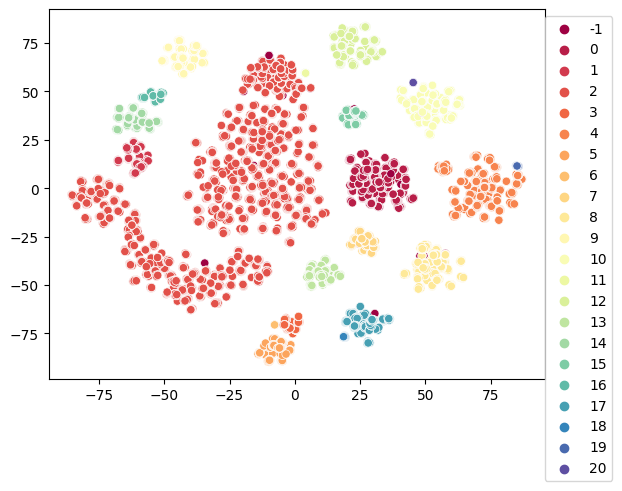

In [345]:
ax = sns.scatterplot(x=tsne_embeding_train[:,0], y=tsne_embeding_train[:,1], hue=db_labels_train, palette='Spectral', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

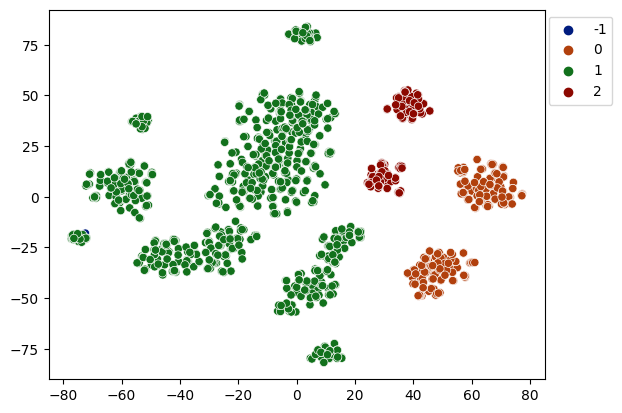

In [163]:
ax = sns.scatterplot(x=tsne_embeding_test[:,0], y=tsne_embeding_test[:,1], hue=db_labels_test, palette= 'dark', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

#### BIRCH
For birch model, the most important parameter is **'n_clusters'** which is the number of clusters and the best value is **2**. The silhouette score is immutable to the other parameters.

In [625]:
birch_model = build_model(n_clusters=16, threshold=8.53, branching_factor=50)[-2]
birch_model.fit(Xtrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numeric',
                                                                   StandardScaler())]),
                                                  Index(['has_null', 'wave', 'age', 'age_o', 'samerace', 'importance_same_race',
       'importance_same_religion', 'pref_o_attractive', 'pref_o_sincere',
       'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious',
       'attractive_o', 'sinsere_o', 'intelligenc...
       'interests_correlate', 'like', 'guess_prob_liked', 'met'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'race', 'race_o'], dtype='object')),
                                                 ('count',
                                                  Pipeline(steps=[('count',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                handle_unknown='ignore'))]),
                                                  Index(['field'], dtype='object'))])),
                ('model', Birch(n_clusters=16, threshold=8.53))])

In [662]:
bc_labels_train = birch_model.fit_predict(Xtrain)

bc_silhouette_score_train = silhouette_score(Xtrain_encoded, bc_labels_train)
print(bc_silhouette_score_train)

0.4782779980931925


In [664]:
print(tsne_embeding_train.shape, bc_labels_train.shape)

(8378, 2) (8378,)


In [673]:
bc_labels_train.shape

(8378,)

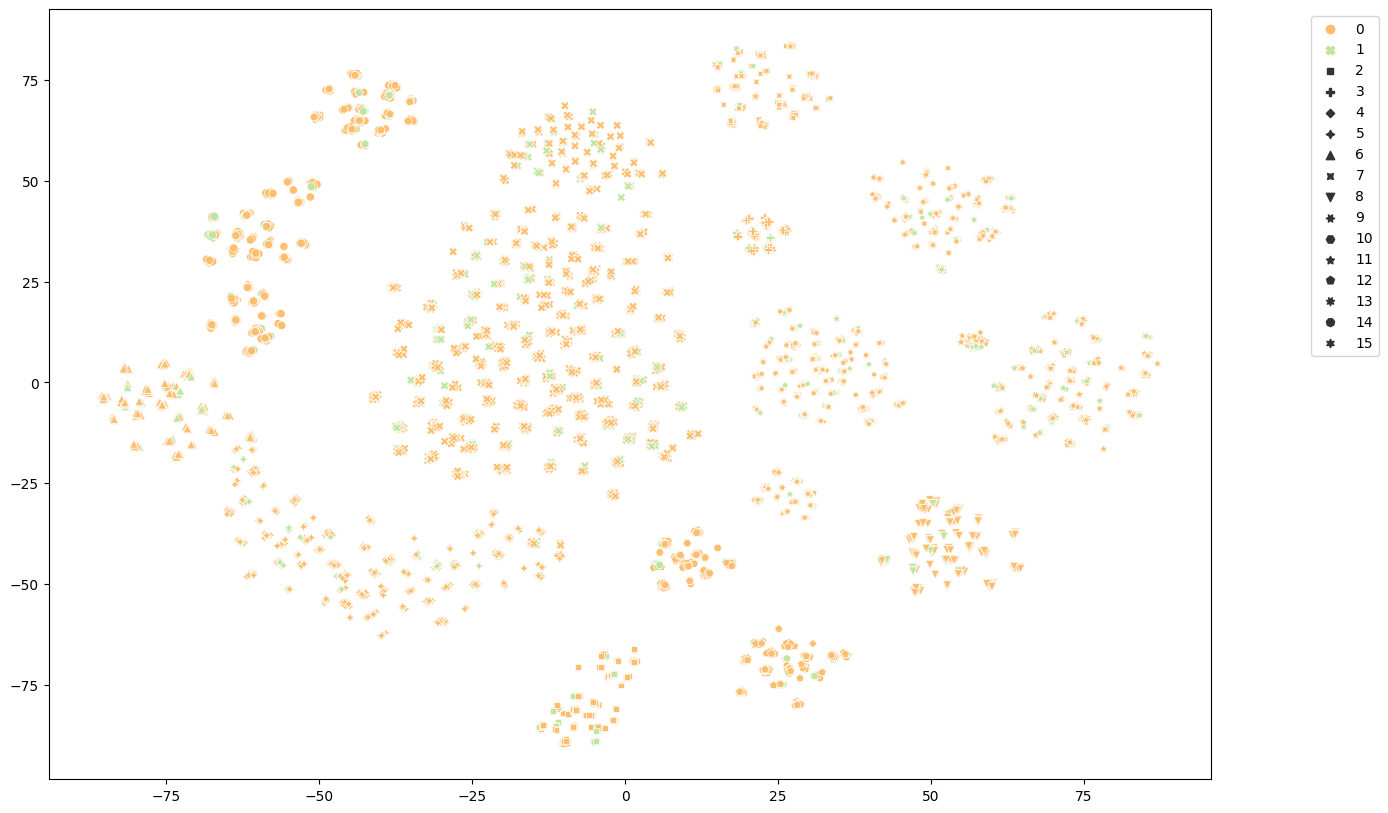

In [685]:
markers = {0: 's', 1: '*'}
fig = plt.figure(figsize=(15, 10))
ax = sns.scatterplot(x=tsne_embeding_train[:,0], 
                    y=tsne_embeding_train[:,1], 
                    hue=ytrain.values.reshape(-1,), 
                    palette= 'Spectral', 
                    style=bc_labels_train, 
                    legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

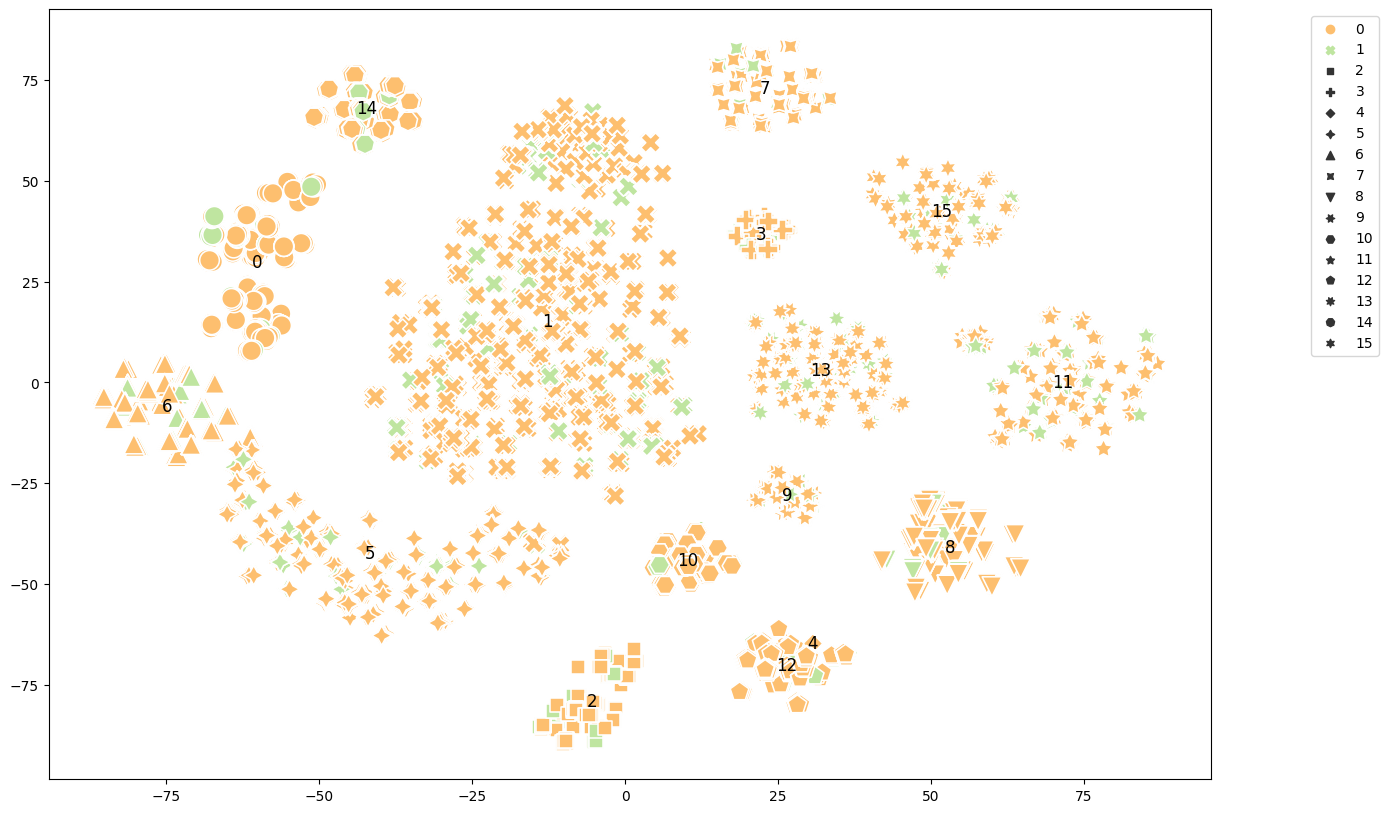

In [694]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15, 10))
ax = sns.scatterplot(x=tsne_embeding_train[:,0], 
                     y=tsne_embeding_train[:,1], 
                     hue=ytrain.values.reshape(-1,), 
                     palette= 'Spectral', 
                     style=bc_labels_train,
                     s=200,
                     legend='full')

centroids = []
for i in np.unique(bc_labels_train):
    centroid = np.mean(tsne_embeding_train[bc_labels_train == i], axis=0)
    centroids.append(centroid)
    ax.text(centroid[0], centroid[1], str(i), fontsize=12, color='black', ha='center', va='center')

ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()


##### The ugly truth of speed dating

In [695]:
import numpy as np

# Assume bc_labels_train contains the cluster labels obtained from Birch
# Find the number of instances in each cluster
cluster_counts = np.bincount(bc_labels_train)

# Print the number of instances in each cluster
for i, count in enumerate(cluster_counts):
    print(f"Cluster {i}: {count} instances")


Cluster 0: 514 instances
Cluster 1: 2460 instances
Cluster 2: 325 instances
Cluster 3: 140 instances
Cluster 4: 2 instances
Cluster 5: 1033 instances
Cluster 6: 387 instances
Cluster 7: 372 instances
Cluster 8: 414 instances
Cluster 9: 177 instances
Cluster 10: 223 instances
Cluster 11: 694 instances
Cluster 12: 285 instances
Cluster 13: 604 instances
Cluster 14: 280 instances
Cluster 15: 468 instances


From above results, we can exclude the 4th cluster. It could be noise that learned by the algorithm that leads to the two instances clustered together.

Next, we calculate the density of person that have a match and do not have a match in each cluster.

In [689]:
n_clusters = len(np.unique(bc_labels_train))

matched_density = np.zeros(n_clusters)

for i in range(n_clusters):
    cluster_indices = np.where(bc_labels_train == i)[0]
    n_matched = np.sum(ytrain.values[cluster_indices])
    matched_density[i] = n_matched / len(cluster_indices)

not_matched_density = np.ones(n_clusters)-matched_density

print(matched_density, '\n', '\n', not_matched_density)

[0.17315175 0.15934959 0.16923077 0.17857143 0.5        0.15972894
 0.17054264 0.15591398 0.11594203 0.18644068 0.13901345 0.20317003
 0.12280702 0.21357616 0.15357143 0.1474359 ] 
 
 [0.82684825 0.84065041 0.83076923 0.82142857 0.5        0.84027106
 0.82945736 0.84408602 0.88405797 0.81355932 0.86098655 0.79682997
 0.87719298 0.78642384 0.84642857 0.8525641 ]


Omit the .5 of 4th cluster, we can roughly tell that the matched and not matched person are distributed in each cluster with nearly the same proportion. As calculated below, in each cluster there are 16% people who find partners in the speed dating. It is kind of interesting that the match ratio is independent to the 

In [703]:
sum_match = 0
sum_unmatch = 0
avg_match = 0
avg_unmatch = 0

for i in range(16):
    sum_match += matched_density[i]
    sum_unmatch += not_matched_density[i]

# print(sum_match, sum_unmatch)

avg_match = (sum_match - 0.5) / 15
avg_unmatch = (sum_unmatch - 0.5) / 15

print(avg_match, avg_unmatch)

0.1632297194947852 0.8367702805052148


In [716]:
rounded_match = np.around(matched_density, 2)
rounded_unmatch = np.around(not_matched_density, 2)

In [717]:
print(rounded_match)
mask = rounded_match == 0.5
rounded_match = rounded_match[~mask]
rounded_match

[0.17 0.16 0.17 0.18 0.5  0.16 0.17 0.16 0.12 0.19 0.14 0.2  0.12 0.21
 0.15 0.15]


array([0.17, 0.16, 0.17, 0.18, 0.16, 0.17, 0.16, 0.12, 0.19, 0.14, 0.2 ,
       0.12, 0.21, 0.15, 0.15])

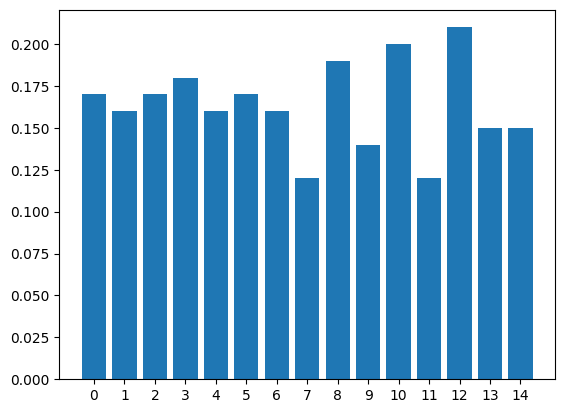

In [734]:
plt.bar(range(len(rounded_match)), rounded_match)
plt.xticks(range(len(rounded_match)))
plt.show()

Obviously, the cluster 9 (8 in the above figure), 11 (10), and 13 (12) have some features of different values that increase the match rate. Now let's try to find what they are.

In [811]:
# add the cluster labels to the encoded data frame
bc_labels_train_df = pd.DataFrame(bc_labels_train, columns = ['birch cluster labels'])
Xtrain_with_cluster_labels = pd.concat([Xtrain_encoded_df, bc_labels_train_df], axis=1)

In [815]:
Xtrain_with_cluster_labels.head()

,has_null,wave,age,age_o,samerace,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,...,race_European/Caucasian-American,race_Latino/Hispanic American,race_Other,race_o_Asian/Pacific Islander/Asian-American,race_o_Black/African American,race_o_European/Caucasian-American,race_o_Latino/Hispanic American,race_o_Other,field,birch cluster labels
0,-2.644669,-1.726435,-1.509911,0.180583,-0.809368,-0.627366,0.126946,1.002114,0.370041,-0.039707,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,604.0,13
1,-2.644669,-1.726435,-1.509911,-1.231257,-0.809368,-0.627366,0.126946,3.001359,-2.484339,-3.004242,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,604.0,13
2,0.378119,-1.726435,-1.509911,-1.231257,1.235531,-0.627366,0.126946,-0.277402,0.084603,-0.187934,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,604.0,13
3,-2.644669,-1.726435,-1.509911,-0.948889,-0.809368,-0.627366,0.126946,0.602265,-1.770744,-0.780841,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,604.0,13
4,-2.644669,-1.726435,-1.509911,-0.666521,-0.809368,-0.627366,0.126946,0.602265,-1.057149,-0.039707,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,604.0,13


In [817]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xtrain_with_cluster_labels, ytrain, test_size=0.2, random_state=42)

##### Next, let's train a random forest model to extract the feature importances

In [820]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

importances = rfc.feature_importances_

/var/folders/pg/t33xxggd1cndkk5fsb62rs_40000gn/T/ipykernel_11730/1129530398.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


Next, let's plot the importances of features

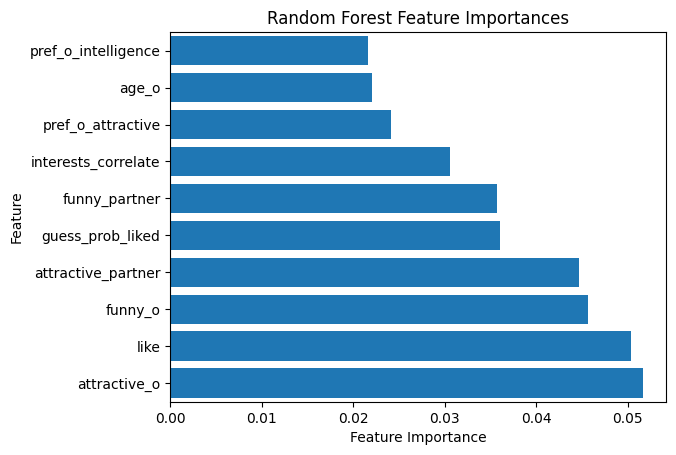

In [845]:
sorted_indices = np.argsort(importances)
sorted_indices = sorted_indices[::-1]

plt.barh(range(X_train.shape[1]), importances[sorted_indices])
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_indices])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.ylim(-0.5, 9.5)
plt.title("Random Forest Feature Importances")
plt.show()

In [848]:
cluster13 = Xtrain_with_cluster_labels[Xtrain_with_cluster_labels['birch cluster labels']==13].sort_values(by='attractive_o', ascending=False)

In [849]:
reducer = TSNE(n_components=2, random_state=42)
embedding = reducer.fit_transform(cluster13)

<Axes: >

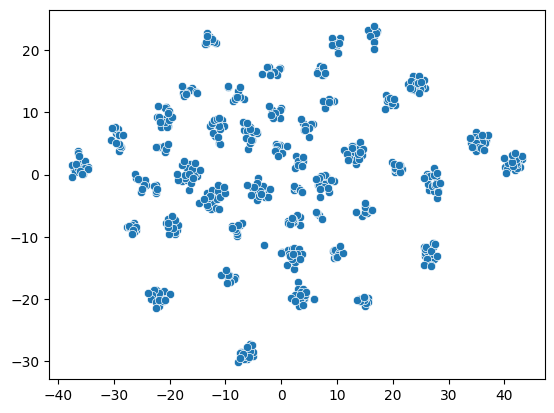

In [851]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1])

**<font color='pink' size='20'> Shape of HEART </font>**  <font size='20'>💖</font>

In [ ]:
bc_labels_test = birch_model.fit_predict(Xtest)

bc_silhouette_score_test = silhouette_score(Xtest_encoded, bc_labels_test)
print(bc_silhouette_score_test)

In [19]:
bc_precision = precision_score(ytest, bc_labels_test, average='weighted')
bc_accuracy = accuracy_score(ytest, bc_labels_test)
bc_f1 = f1_score(ytest, bc_labels_test)

print(f'Precision score of birch model is: {bc_precision}')
print(f'Accuracy score of birch model is: {bc_accuracy}')
print(f'F1 score of birch model is: {bc_f1}')

Precision score of birch model is: 0.6969367060158181
Accuracy score of birch model is: 0.3347255369928401
F1 score of birch model is: 0.26499670402109426


In [ ]:
ax = sns.scatterplot(x=tsne_embeding_test[:,0], y=tsne_embeding_test[:,1], hue=bc_labels_test, palette= 'dark', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

#### KMEANS


In [658]:
models = build_model(n_clusters=16, init='random', n_init=4, max_iter=300, tol=1e-8, verbose=8, random_state=42, algorithm_k='lloyd')
km_model = models[1]
km_model.fit(Xtrain)

Initialization complete
Iteration 0, inertia 4029529.7657196643.
Iteration 1, inertia 2379061.206940025.
Iteration 2, inertia 2014862.552597643.
Iteration 3, inertia 2007903.0318820933.
Iteration 4, inertia 2004584.1729828045.
Iteration 5, inertia 2003658.3004944946.
Iteration 6, inertia 2003389.8387642931.
Iteration 7, inertia 2003197.2563898363.
Iteration 8, inertia 2003044.4164570055.
Iteration 9, inertia 2002886.7647472671.
Iteration 10, inertia 2002796.8865362261.
Iteration 11, inertia 2002725.3610889614.
Iteration 12, inertia 2002642.580584372.
Iteration 13, inertia 2002527.2952017607.
Iteration 14, inertia 2002504.4323210912.
Iteration 15, inertia 2002502.994826535.
Converged at iteration 15: strict convergence.
Initialization complete
Iteration 0, inertia 16129333.647846831.
Iteration 1, inertia 5091144.032951234.
Iteration 2, inertia 2186271.5224847505.
Iteration 3, inertia 1594903.6291543858.
Iteration 4, inertia 1559398.0588052433.
Iteration 5, inertia 1537198.2594909375.
It

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numeric',
                                                                   StandardScaler())]),
                                                  Index(['has_null', 'wave', 'age', 'age_o', 'samerace', 'importance_same_race',
       'importance_same_religion', 'pref_o_attractive', 'pref_o_sincere',
       'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious',
       'attractive_o', 'sinsere_o', 'intelligenc...
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'race', 'race_o'], dtype='object')),
                                                 ('count',
                                                  Pipeline(steps=[('count',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                handle_unknown='ignore'))]),
                                                  Index(['field'], dtype='object'))])),
                ('model',
                 KMeans(init='random', n_clusters=16, n_init=4, random_state=42,
                        tol=1e-08, verbose=8))])

In [659]:
km_labels_train = km_model.fit_predict(Xtrain)

km_silhouette_score_train = silhouette_score(Xtrain_encoded, km_labels_train)
print(km_silhouette_score_train)

Initialization complete
Iteration 0, inertia 4029529.7657196643.
Iteration 1, inertia 2379061.206940025.
Iteration 2, inertia 2014862.5525976429.
Iteration 3, inertia 2007903.031882093.
Iteration 4, inertia 2004584.1729828045.
Iteration 5, inertia 2003658.3004944946.
Iteration 6, inertia 2003389.8387642931.
Iteration 7, inertia 2003197.2563898363.
Iteration 8, inertia 2003044.416457005.
Iteration 9, inertia 2002886.7647472671.
Iteration 10, inertia 2002796.8865362261.
Iteration 11, inertia 2002725.3610889614.
Iteration 12, inertia 2002642.580584372.
Iteration 13, inertia 2002527.295201761.
Iteration 14, inertia 2002504.432321091.
Iteration 15, inertia 2002502.994826535.
Converged at iteration 15: strict convergence.
Initialization complete
Iteration 0, inertia 16129333.647846831.
Iteration 1, inertia 5091144.032951236.
Iteration 2, inertia 2186271.52248475.
Iteration 3, inertia 1594903.629154386.
Iteration 4, inertia 1559398.0588052433.
Iteration 5, inertia 1537198.2594909375.
Iteratio

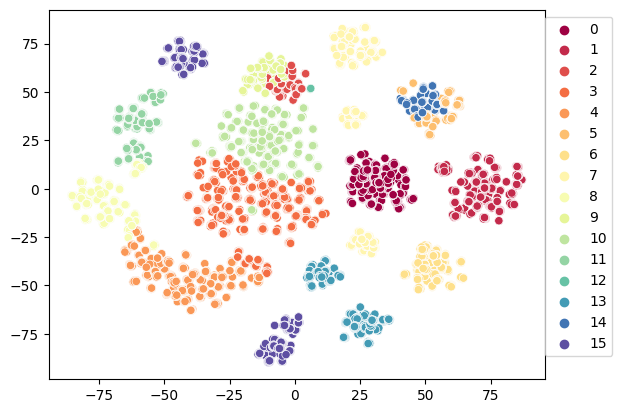

In [660]:
ax = sns.scatterplot(x=tsne_embeding_train[:,0], y=tsne_embeding_train[:,1], hue=km_labels_train, palette= 'Spectral', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

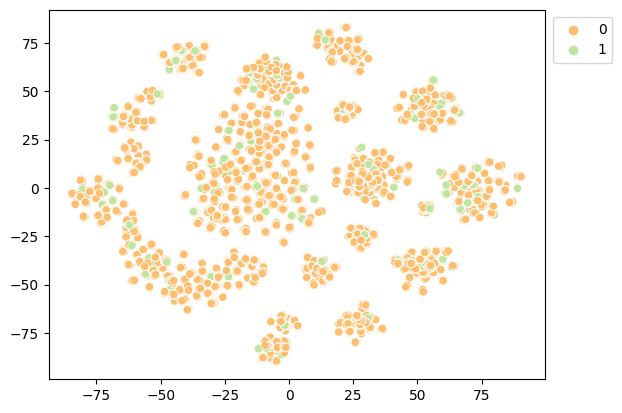

In [304]:
ax = sns.scatterplot(x=tsne_embeding_train[:,0], y=tsne_embeding_train[:,1], hue=ytrain.values.reshape((-1,)), palette= 'Spectral', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

In [204]:
# km_labels_test = km_model.fit_predict(Xtest)

# km_silhouette_score_test = silhouette_score(Xtest_encoded, km_labels_test)
# print(km_silhouette_score_test)

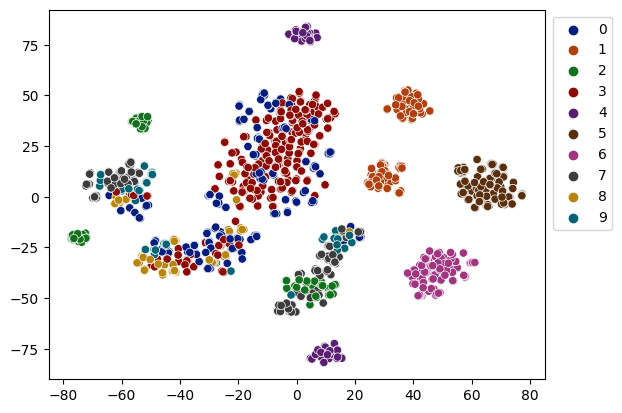

In [158]:
ax = sns.scatterplot(x=tsne_embeding_test[:,0], y=tsne_embeding_test[:,1], hue=bc_labels_test, palette= 'dark', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

#### OPTICS

- Valid values for metric are:

    - from scikit-learn: [‘cityblock’, ‘cosine’, ‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’]

    - from scipy.spatial.distance: [‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘correlation’, ‘dice’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’]

    Sparse matrices are only supported by scikit-learn metrics. See the documentation for scipy.spatial.distance for details on these metrics.

- Algorithm used to compute the nearest neighbors:

    - ‘ball_tree’ will use BallTree.

    - ‘kd_tree’ will use KDTree.

    - ‘brute’ will use a brute-force search.

    - ‘auto’ (default) will attempt to decide the most appropriate algorithm based on the values passed to fit method.

In [169]:
# TODO: before changing the metric parameter, try different min_samples
models = build_model(min_samples=50, metric='euclidean', p=2, cluster_method='xi', min_cluster_size=2, algorithm='auto', leaf_size=30)
op_model = models[2]
op_model.fit(Xtrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numeric',
                                                                   StandardScaler())]),
                                                  Index(['wave', 'age', 'age_o', 'd_age', 'samerace', 'importance_same_race',
       'importance_same_religion', 'pref_o_attractive', 'pref_o_sincere',
       'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious',
       'pref_o_shared_interests', 'attractive_o', '...
       'd_yoga', 'd_interests_correlate', 'd_expected_happy_with_sd_people',
       'd_expected_num_interested_in_me', 'd_expected_num_matches', 'd_like',
       'd_guess_prob_liked'],
      dtype='object')),
                                                 ('count',
                                                  Pipeline(steps=[('count',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                handle_unknown='ignore'))]),
                                                  Index(['field'], dtype='object'))])),
                ('model',
                 OPTICS(metric='euclidean', min_cluster_size=2,
                        min_samples=50))])

In [176]:
op_labels_train = op_model.fit_predict(Xtrain)
op_labels_test = op_model.fit_predict(Xtest)
# op_silhouette_score_train = silhouette_score(Xtrain_encoded, op_labels_train)
# op_silhouette_score_test = silhouette_score(Xtest_encoded, op_labels_test)
# print(op_silhouette_score_train)
# print(op_silhouette_score_test)

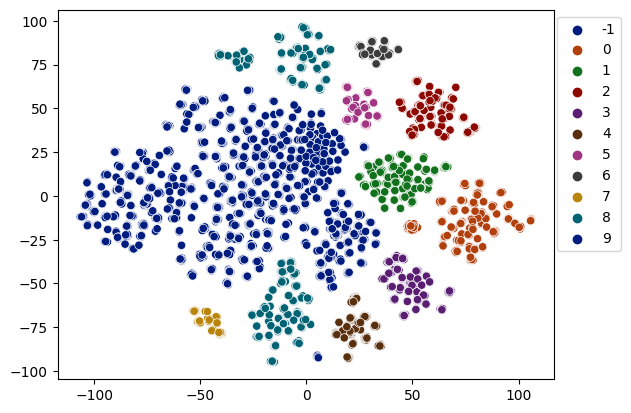

In [177]:
ax = sns.scatterplot(x=tsne_embeding_train[:,0], y=tsne_embeding_train[:,1], hue=op_labels_train, palette= 'dark', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

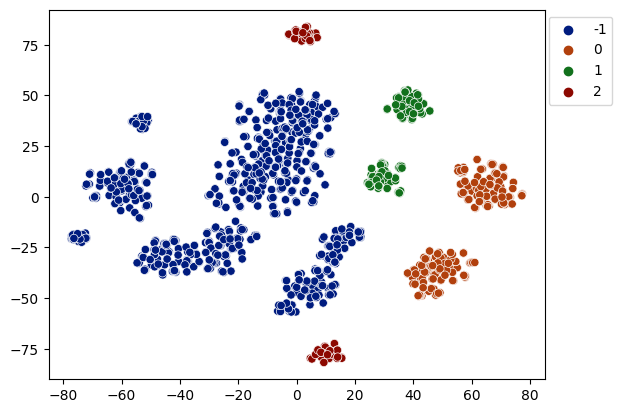

In [178]:
ax = sns.scatterplot(x=tsne_embeding_test[:,0], y=tsne_embeding_test[:,1], hue=op_labels_test, palette= 'dark', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

The 'affinity' parameter of AgglomerativeClustering must be a str among {'sokalmichener', 'rogerstanimoto', 'cosine', 'braycurtis', 'sokalsneath', 'dice', 'nan_euclidean', 'precomputed', 'l2', 'matching', 'canberra', 'l1', 'yule', 'cityblock', 'kulsinski', 'correlation', 'jaccard', 'sqeuclidean', 'euclidean', 'haversine', 'seuclidean', 'hamming', 'wminkowski', 'russellrao', 'manhattan', 'mahalanobis', 'minkowski', 'chebyshev'} or a callable

In [179]:
from sklearn.cluster import AgglomerativeClustering

# sokalmichener: silhouette score: 0.298, same as rogerstanimoto, matching, kulsinski, hamming. 
# canberra: silhouette score: 0.2437. yule: 0.105. 
# correlation: silhouette score: -0.8097. 
# jaccard: silhouette score: 0.25. 
# seuclidean: silhouette score: 0.394.

agg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', AgglomerativeClustering(n_clusters=12, linkage='average', metric='seuclidean'))
])

In [180]:
agg.fit(Xtrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numeric',
                                                                   StandardScaler())]),
                                                  Index(['wave', 'age', 'age_o', 'd_age', 'samerace', 'importance_same_race',
       'importance_same_religion', 'pref_o_attractive', 'pref_o_sincere',
       'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious',
       'pref_o_shared_interests', 'attractive_o', '...
       'd_yoga', 'd_interests_correlate', 'd_expected_happy_with_sd_people',
       'd_expected_num_interested_in_me', 'd_expected_num_matches', 'd_like',
       'd_guess_prob_liked'],
      dtype='object')),
                                                 ('count',
                                                  Pipeline(steps=[('count',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                handle_unknown='ignore'))]),
                                                  Index(['field'], dtype='object'))])),
                ('model',
                 AgglomerativeClustering(linkage='average', metric='seuclidean',
                                         n_clusters=12))])

In [181]:
agg_labels_train = agg.fit_predict(Xtrain)
agg_labels_test = agg.fit_predict(Xtest)
# agg_silhou_train = silhouette_score(Xtrain_encoded, agg_labels_train.reshape(-1, ))
# agg_silhou_test = silhouette_score(Xtest_encoded, agg_labels_test.reshape(-1, ))
# print('Silhouette score of agglomerative cluster model on train dataset: ', agg_silhou_train)
# print('Silhouette score of agglomerative cluster model on test dataset: ', agg_silhou_test)

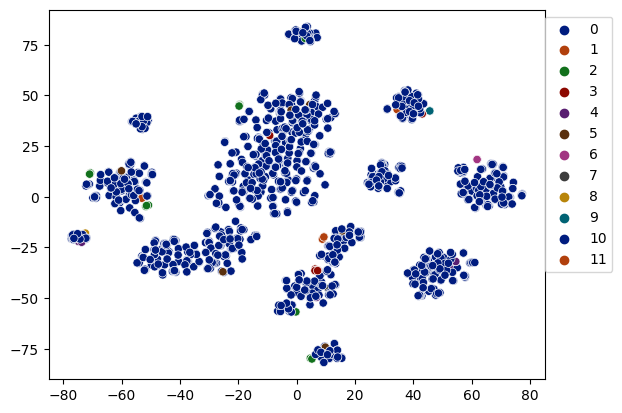

In [182]:
ax = sns.scatterplot(x=tsne_embeding_test[:,0], y=tsne_embeding_test[:,1], hue=agg_labels_test, palette= 'dark', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

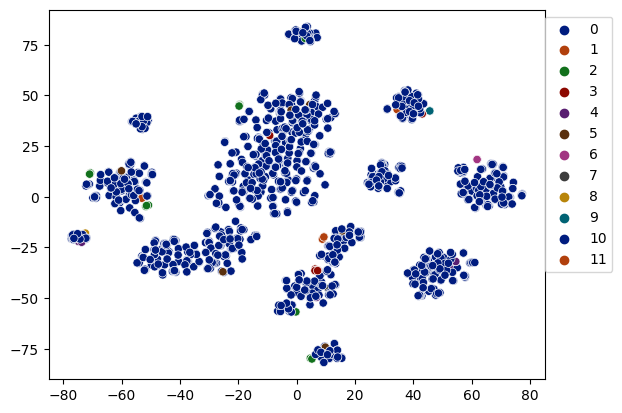

In [186]:
ax = sns.scatterplot(x=tsne_embeding_test[:,0], y=tsne_embeding_test[:,1], hue=agg_labels_test, palette= 'dark', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

In [193]:
from sklearn.cluster import BisectingKMeans

bikm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', BisectingKMeans(n_clusters=8, init='k-means++', n_init=20))
])
bikm.fit(Xtrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numeric',
                                                                   StandardScaler())]),
                                                  Index(['wave', 'age', 'age_o', 'd_age', 'samerace', 'importance_same_race',
       'importance_same_religion', 'pref_o_attractive', 'pref_o_sincere',
       'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious',
       'pref_o_shared_interests', 'attractive_o', '...
       'd_yoga', 'd_interests_correlate', 'd_expected_happy_with_sd_people',
       'd_expected_num_interested_in_me', 'd_expected_num_matches', 'd_like',
       'd_guess_prob_liked'],
      dtype='object')),
                                                 ('count',
                                                  Pipeline(steps=[('count',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                handle_unknown='ignore'))]),
                                                  Index(['field'], dtype='object'))])),
                ('model', BisectingKMeans(init='k-means++', n_init=20))])

In [194]:
bikm_labels_train = bikm.fit_predict(Xtrain)
bikm_labels_test = bikm.fit_predict(Xtest)

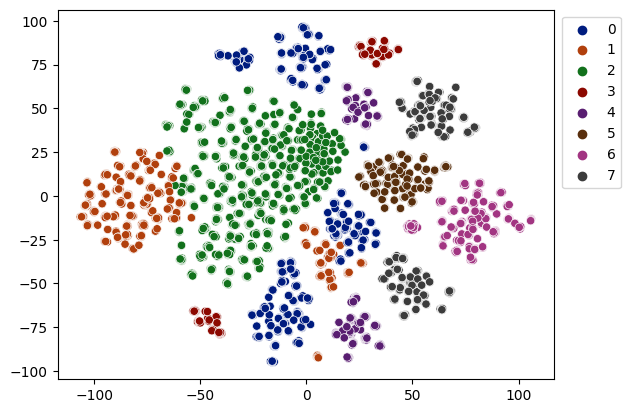

In [195]:
ax = sns.scatterplot(x=tsne_embeding_train[:,0], y=tsne_embeding_train[:,1], hue=bikm_labels_train, palette= 'dark', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

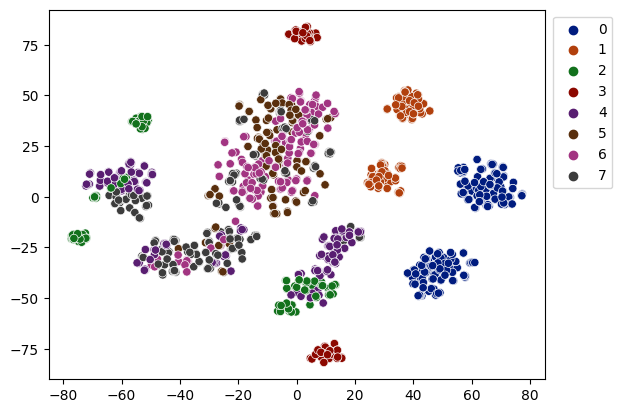

In [196]:
ax = sns.scatterplot(x=tsne_embeding_test[:,0], y=tsne_embeding_test[:,1], hue=bikm_labels_test, palette= 'dark', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

### Back to Feature selection
By adjusting parameters of model, we found that the evaluation metrics are still small. While when we checked the dataset, we found that the number of features is doubled. Therefore, we have a sparse dataset. To resolve this problem. we can use feature selection method to choose the features that are of higher importance. 

(5864, 240) (5864, 120)
